## Compare DE effect of single guides

In [ ]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import glob
from tqdm import tqdm
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


sys.path.append(os.path.abspath('../../'))
from utils import _convert_oak_path
from merge_DE_results import parse_DE_results_2_adata

In [ ]:
import yaml

# Load color palettes from yaml file
with open('../../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [3]:

from DE_analysis_utils import *

In [4]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil

In [ ]:
# datadir = '/mnt/oak/users/emma/data/GWT/'
# experiment_name = 'CD4i_final'
# all_correlations = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
# all_correlations.head()

,target,correlation,correlation_ceiling,n_signif_union,n_signif_1,n_signif_2,culture_condition
0,A2M,-0.466086,NaN,10,0,10,Rest
1,ABCC1,0.084480,NaN,84,84,1,Rest
2,ABHD12,0.490760,0.628502,360,1,360,Rest
3,ABHD13,-0.301527,0.527995,507,506,3,Rest
4,ABHD14A,0.958795,0.943289,5,1,5,Rest


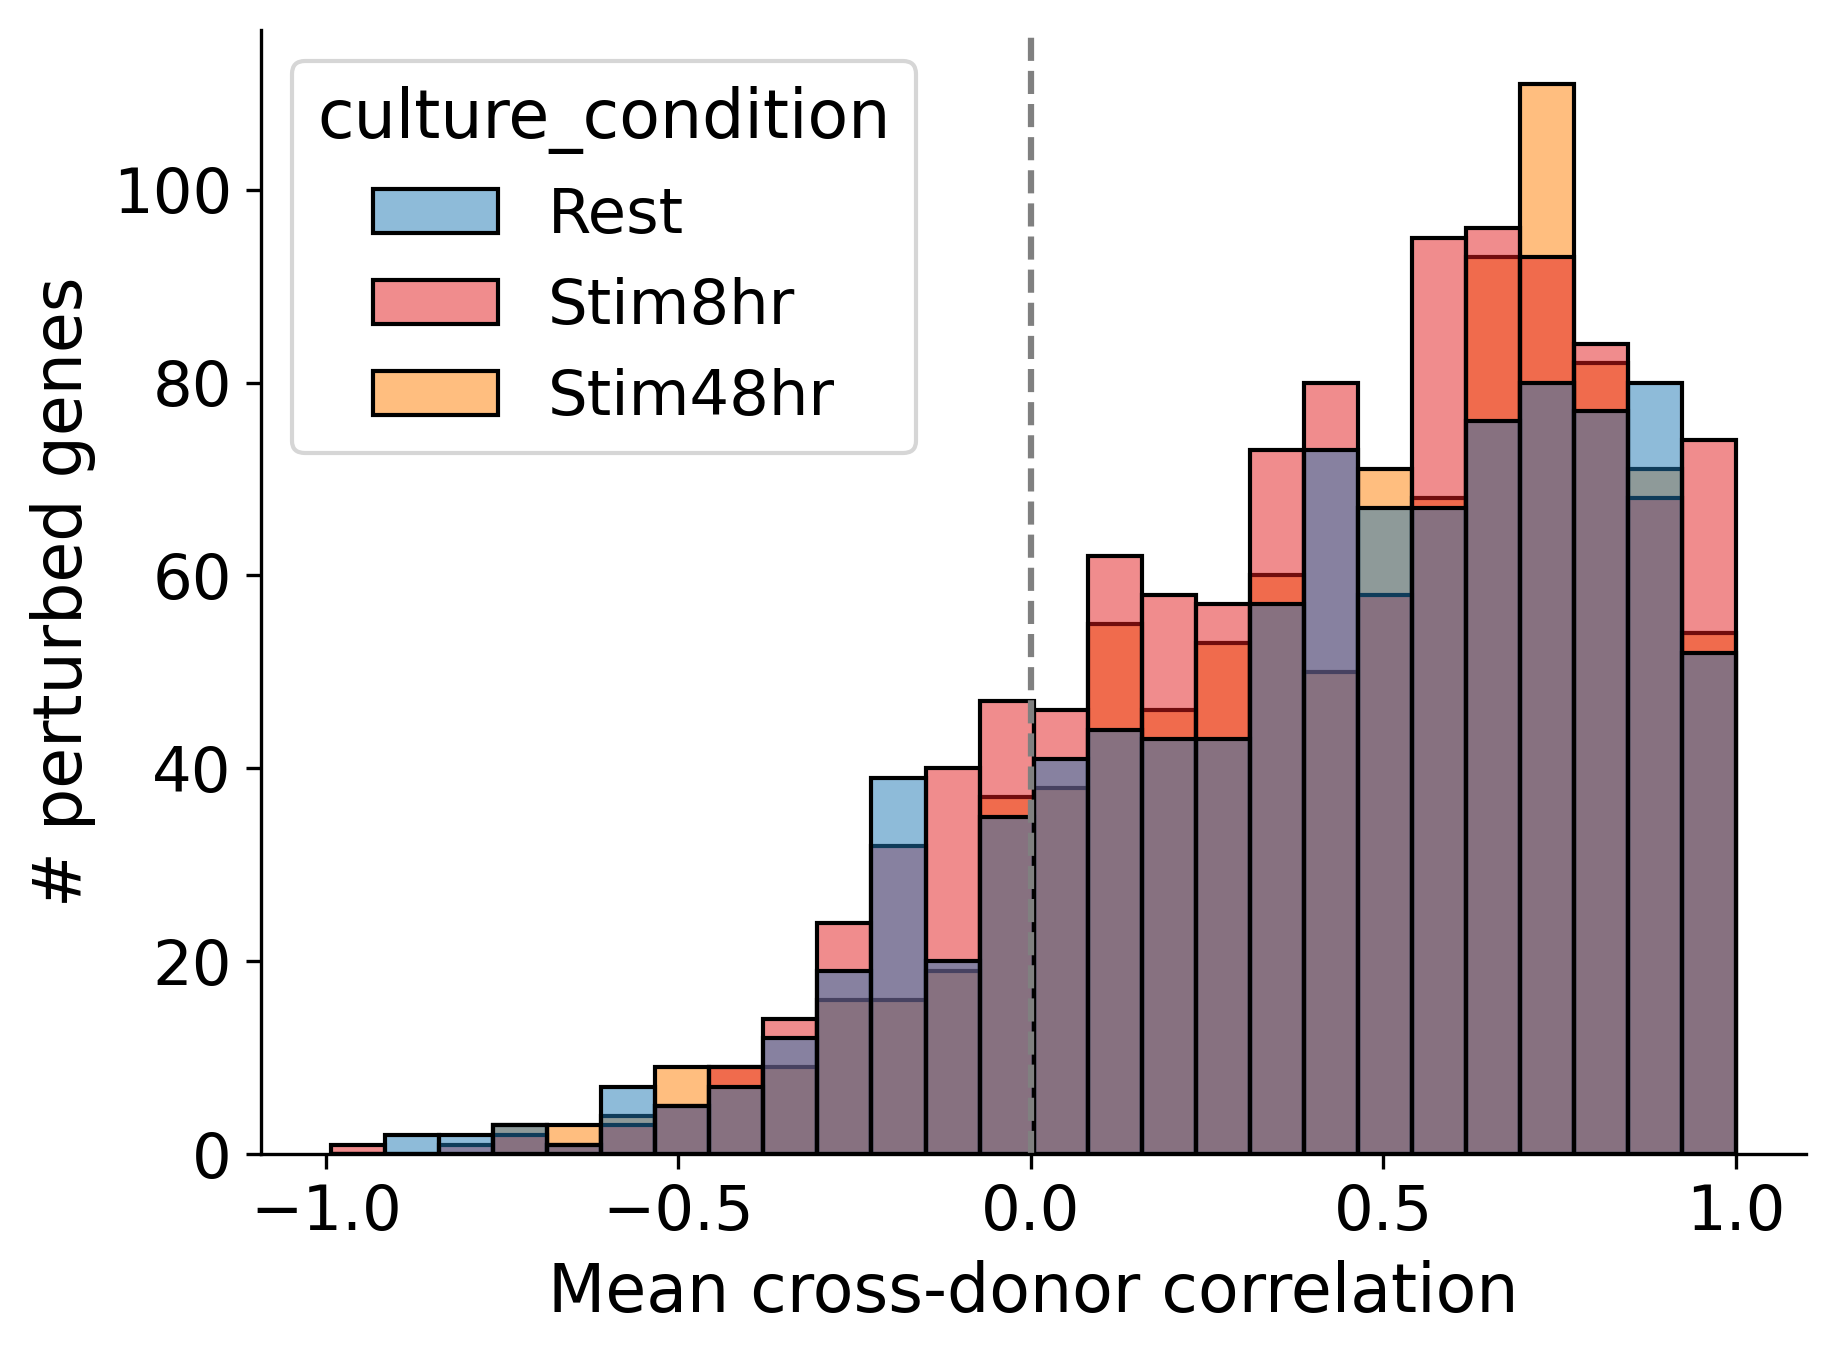

In [10]:
def plot_effect_comparison(
    adata_de,
    comparison_params,
    n_top_genes=15,
    plot_correlation=False,
    axis_label='DE effect',
    corr_coords_xy=(0.01, 0.95),
    figsize=(8, 8),
    ax=None,
    annotate_genes=None
):
    """
    Scatter plot comparing DE effects on all tested genes for a pair of conditions, targets or stats.

    Parameters:
    -----------
    adata_de : AnnData
        AnnData object containing DE analysis results
    comparison_params : dict
        Dictionary with parameters for comparison (put 2 values for parameter you want to compare on x or y axis)
        - 'target_contrast_gene_name': list of target genes to analyze
        - 'stat': list of statistics to use (e.g., 'MASH_PosteriorMean')
        - 'culture_condition': list of conditions to compare
    n_top_genes : int, default=15
        Number of top/bottom genes to annotate on each axis (ignored if annotate_genes is provided)
    plot_correlation : bool, default=False
        Whether to plot correlation statistics
    ax : matplotlib.axes.Axes, optional
        Pre-existing axes for the plot. If None, a new figure and axes will be created.
    annotate_genes : list or None, optional
        List of gene names to annotate on the plot. If None, will annotate top/bottom genes as before.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure (None if ax was provided)
    ax : matplotlib.axes.Axes
        The axes containing the plot
    pl_df : pandas.DataFrame
        The dataframe used for plotting
    """
    # Validate parameters
    compare = [k for k, v in comparison_params.items() if len(v) == 2]
    if len(compare) > 1:
        raise ValueError(f"More than one parameter has length 2: {', '.join(compare)}")
    else:
        compare = compare[0]

    # Get DE results
    res_df = get_DE_results_long(
        adata_de,
        targets=comparison_params['target_contrast_gene_name'],
        effect_estimates=comparison_params['stat'],
        gene_id_col='gene_name',
        target_id_col='target_contrast_gene_name',
        target_metadata_cols=['culture_condition']
    )
    res_df = res_df[res_df['culture_condition'].isin(comparison_params['culture_condition'])]

    # Create pivot table
    if compare != 'stat':
        pl_df = res_df.pivot(columns=compare, index='gene', values=comparison_params['stat'][0])
    else:
        pl_df = res_df[comparison_params['stat'] + ['gene']].set_index('gene')

    # Create figure if ax is not provided
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Get column names for x and y axis labels
    x_col = pl_df.columns[0]  # First column (likely 'Rest')
    y_col = pl_df.columns[1]  # Second column (likely 'Stim8hr')

    # Create scatter plot using column names from pl_df
    sns.scatterplot(data=pl_df, x=x_col, y=y_col, s=4, edgecolor='none', color='black', ax=ax)

    # Add dotted lines for x and y axes
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    ax.axvline(x=0, color='gray', linestyle=':', linewidth=1)

    if plot_correlation:
        # Calculate correlation between the two conditions
        corr, pval = scipy.stats.pearsonr(pl_df[x_col], pl_df[y_col])

        # Add correlation information as text
        ax.annotate(
            f'Correlation: {corr:.3f}\n(p{" < 10e-16" if pval < 1e-16 else f" = {pval:.3e}"})',
            xy=corr_coords_xy, xycoords='axes fraction', fontsize=12
        )

    # Add axis labels and title
    ax.set_xlabel(f'{axis_label} ({x_col})', fontsize=12)
    ax.set_ylabel(f'{axis_label} ({y_col})', fontsize=12)
    ax.set_title(f'{comparison_params["target_contrast_gene_name"][0]} knock-out effect\n{x_col} vs {y_col} comparison', fontsize=14)

    # Annotate genes
    texts = []
    if annotate_genes is not None:
        # Only annotate the specified genes if they are present in pl_df
        for gene in annotate_genes:
            if gene in pl_df.index:
                row = pl_df.loc[gene]
                # Use a default color for user-specified genes
                color = 'darkgreen'
                texts.append(ax.text(row[x_col], row[y_col], gene, fontsize=8, color=color))
    else:
        # Annotate genes with extreme values (top/bottom)
        top_genes_y = pl_df.nlargest(n_top_genes, y_col)
        bottom_genes_y = pl_df.nsmallest(n_top_genes, y_col)
        top_genes_x = pl_df.nlargest(n_top_genes, x_col)
        bottom_genes_x = pl_df.nsmallest(n_top_genes, x_col)
        extreme_genes = pd.concat([top_genes_y, bottom_genes_y, top_genes_x, bottom_genes_x]).drop_duplicates()
        for idx, row in extreme_genes.iterrows():
            # Color based on which category the gene falls into
            if idx in top_genes_y.index or idx in top_genes_x.index:
                color = 'darkred'
            else:
                color = 'darkblue'
            texts.append(ax.text(row[x_col], row[y_col], idx, fontsize=8, color=color))

    # Use adjustText to avoid overlapping labels
    from adjustText import adjust_text
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        expand_points=(1.5, 1.5),
        force_points=(0.5, 0.5),
        ax=ax
    )

    if fig is not None:
        return fig, ax, pl_df
    else:
        return ax, pl_df

In [11]:
config = 'DE_config_by_guide.yaml'
with open(config, 'r') as config_file:
    config = yaml.safe_load(config_file)
config

{'experiment_name': 'CD4i_final',
 'datadir': '/mnt/oak/users/emma/data/GWT/',
 'run_name': 'single_guide',
 'min_replicates': 3,
 'min_cells_per_guide': 5,
 'n_hvgs': 10000,
 'min_counts_quantile': 0.005,
 'chunk_size': 50,
 'chunk_split_seed': 1423,
 'feature_selection': {'highx_min_mean_counts': 10000,
  'highx_min_pct_dropouts': 0.9,
  'lowx_min_counts': 1,
  'lowx_max_pct_dropouts': 99.9},
 'run_DE_params': {'min_counts_per_gene': 10,
  'design_formula': '~ log10_n_cells + target'},
 'file_paths': {'no_effect_guides_file': 'no_effect_guides.txt',
  'de_test_genes_file': 'DE_test_genes.txt',
  'target2chunk_file': 'DE_single_guide_target2chunk.csv.gz'}}

In [13]:
# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']
datadir = f'{datadir}/{experiment_name}/'
run_name = config.get('run_name', 'default')
force_combine = True

# # Read cell-level metadata
# sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
# gene_name_to_guide_id = dict(zip(sgrna_library_metadata['sgrna_id'], sgrna_library_metadata['perturbed_gene_name']))
# var_df = sc.read_h5ad(f'{datadir}/{experiment_name}_merged_by_guide.DE_pseudobulk.h5ad', backed=True).var.copy()
# de_results_dir = datadir + f'/DE_results_{run_name}/tmp/'

In [ ]:
# var_df.head()

,gene_ids,gene_name
CUSTOM001_PuroR,CUSTOM001_PuroR,PuroR
ENSG00000000003,ENSG00000000003,TSPAN6
ENSG00000000005,ENSG00000000005,TNMD
ENSG00000000419,ENSG00000000419,DPM1
ENSG00000000457,ENSG00000000457,SCYL3


In [ ]:
# de_results_files = glob.glob(de_results_dir + 'DE_results_by_guide.*.csv.gz')

In [ ]:
# de_results_adatas = []

# for file in tqdm(de_results_files, desc="Processing DE result files"):
#     # try:
#     df = pd.read_csv(file, compression='gzip', index_col=0)
#     df = df.rename({'contrast': 'target_contrast'}, axis=1)
#     df['target_contrast_gene_name'] = df['target_contrast'].map(lambda x: gene_name_to_guide_id.get(x, x))
#     de_results_adatas.append(parse_DE_results_2_adata(df))
#     # except EOFError:
#     #     continue

# combined_de_adata = anndata.concat(de_results_adatas, label='chunk')
# # combined_de_adata.obs_names = combined_de_adata.obs_names.str.split('-').str[0]
# assert combined_de_adata.obs_names.is_unique

Processing DE result files: 100%|██████████| 131/131 [03:22<00:00,  1.54s/it]


In [ ]:
# # Add gene names
# combined_de_adata.var = var_df.loc[combined_de_adata.var_names]
# combined_de_adata.layers['zscore'] = combined_de_adata.layers['log_fc'] / combined_de_adata.layers['lfcSE']
# combined_de_adata.obs['n_cells_target'] = 1

In [ ]:
# de_counts = get_de_stats(combined_de_adata, effect_col='zscore', signif_col='adj_p_value', alpha=0.1)
# de_counts.head()

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes
ADAT3-2_Stim8hr,ADAT3-2,ADAT3,Stim8hr,1,45,12,57
AP1S2-2_Stim8hr,AP1S2-2,AP1S2,Stim8hr,1,67,21,88
ARPC2-2_Stim8hr,ARPC2-2,ARPC2,Stim8hr,1,272,81,353
ARPC3-2_Stim8hr,ARPC3-2,ARPC3,Stim8hr,1,71,22,93
BCAP29-2_Stim8hr,BCAP29-2,BCAP29,Stim8hr,1,0,1,1


In [ ]:
# de_counts.value_counts(['condition'])

condition
Stim8hr      2350
Stim48hr     2118
Rest         2040
Name: count, dtype: int64

In [ ]:
# combined_de_adata.write_h5ad(datadir + f'/DE_results_{run_name}/{experiment_name}.merged_DE_results_by_guide.h5ad')

In [15]:
combined_de_adata = sc.read_h5ad(datadir + f'{experiment_name}.merged_DE_results_by_guide.h5ad')

In [20]:
de_counts = get_de_stats(combined_de_adata, effect_col='zscore', signif_col='adj_p_value', alpha=0.1)
combined_de_adata.obs.target_contrast_gene_name

ADAT3-2_Stim8hr       ADAT3
AP1S2-2_Stim8hr       AP1S2
ARPC2-2_Stim8hr       ARPC2
ARPC3-2_Stim8hr       ARPC3
BCAP29-2_Stim8hr     BCAP29
                      ...  
TXNDC9-2_Stim48hr    TXNDC9
USP22-2_Stim48hr      USP22
UTP23-1_Stim48hr      UTP23
UTP23-2_Stim48hr      UTP23
VBP1-1_Stim48hr        VBP1
Name: target_contrast_gene_name, Length: 6508, dtype: category
Categories (1796, object): ['A2M', 'AAGAB', 'AASDH', 'ABCA5', ..., 'ZSCAN23', 'ZSCAN25', 'ZSWIM4', 'ZSWIM9']

## Assess correlation between guides

In [21]:
all_conditions = ['Rest', 'Stim8hr', 'Stim48hr']
correlations_all = []

for c in all_conditions:
    guide_counts = combined_de_adata.obs[combined_de_adata.obs.culture_condition == c].target_contrast_gene_name.value_counts()
    test_targets = guide_counts[guide_counts == 2].index.tolist()

    cond_de_counts = de_counts[de_counts['condition'] == c]
    test_targets = cond_de_counts[cond_de_counts.target_name.isin(test_targets) & (cond_de_counts['n_total_de_genes'] > 2)].sort_values(['target_name']).target_name.unique()
    len(test_targets)
    lfc_df = sc.get.obs_df(
        combined_de_adata[combined_de_adata.obs.culture_condition == c], combined_de_adata.var_names.tolist() + ['target_contrast_gene_name'], layer='log_fc')
    lfcse_df = sc.get.obs_df(
        combined_de_adata[combined_de_adata.obs.culture_condition == c], combined_de_adata.var_names.tolist() + ['target_contrast_gene_name'], layer='lfcSE')
    fdr_df = sc.get.obs_df(
        combined_de_adata[combined_de_adata.obs.culture_condition == c], combined_de_adata.var_names.tolist() + ['target_contrast_gene_name'], layer='adj_p_value')
    correlations = []
    for t in tqdm(test_targets, desc="Calculating guide correlations"):
        lfc_pair = lfc_df[lfc_df['target_contrast_gene_name'] == t].T.drop('target_contrast_gene_name')
        lfcse_pair = lfcse_df[lfcse_df['target_contrast_gene_name'] == t].T.drop('target_contrast_gene_name')
        fdr_pair = fdr_df[fdr_df['target_contrast_gene_name'] == t].T.drop('target_contrast_gene_name')

        # Get mask for genes with p < 0.1 in either test
        sig_mask = (fdr_pair.iloc[:,0] < 0.1) | (fdr_pair.iloc[:,1] < 0.1)

        # Filter data using mask
        data1 = lfc_pair.iloc[:,0][sig_mask]
        data2 = lfc_pair.iloc[:,1][sig_mask]
        se1 = lfcse_pair.iloc[:,0][sig_mask] 
        se2 = lfcse_pair.iloc[:,1][sig_mask]

        # Calculate correlation and ceiling
        corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

        correlations.append({
            'target': t,
            'correlation': corr,
            'correlation_ceiling': corr_ceil,
            'n_signif_union': data1.shape[0],
            'n_signif_1': (fdr_pair.iloc[:,0] < 0.1).sum(),
            'n_signif_2': (fdr_pair.iloc[:,1] < 0.1).sum(),
            'culture_condition': c
        })
    correlations_all.extend(correlations)

correlations_df = pd.DataFrame(correlations_all)

Calculating guide correlations:   0%|          | 0/952 [00:00<?, ?it/s]/tmp/ipykernel_152310/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_152310/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
Calculating guide correlations:   3%|▎         | 24/952 [00:00<00:08, 114.14it/s]/tmp/ipykernel_152310/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_152310/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_152310/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
Calculating guide correlations:   5%|▌         | 50/952 [00:00<00:07, 119.03it/s]/tmp/ipykernel_152310/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_152310/3615270918.py

In [23]:
correlations_df.head()

,target,correlation,correlation_ceiling,n_signif_union,n_signif_1,n_signif_2,culture_condition
0,A2M,-0.466086,NaN,10,0,10,Rest
1,ABCC1,0.084480,NaN,84,84,1,Rest
2,ABHD12,0.490760,0.628502,360,1,360,Rest
3,ABHD13,-0.301527,0.527995,507,506,3,Rest
4,ABHD14A,0.958795,0.943289,5,1,5,Rest


In [24]:
correlations_df.to_csv("./results/DE_by_guide.correlation_results.csv")

In [5]:
correlations_df = pd.read_csv("./results/DE_by_guide.correlation_results.csv")

In [59]:
correlations_df.culture_condition.value_counts()

culture_condition
Stim8hr     1123
Stim48hr     977
Rest         952
Name: count, dtype: int64

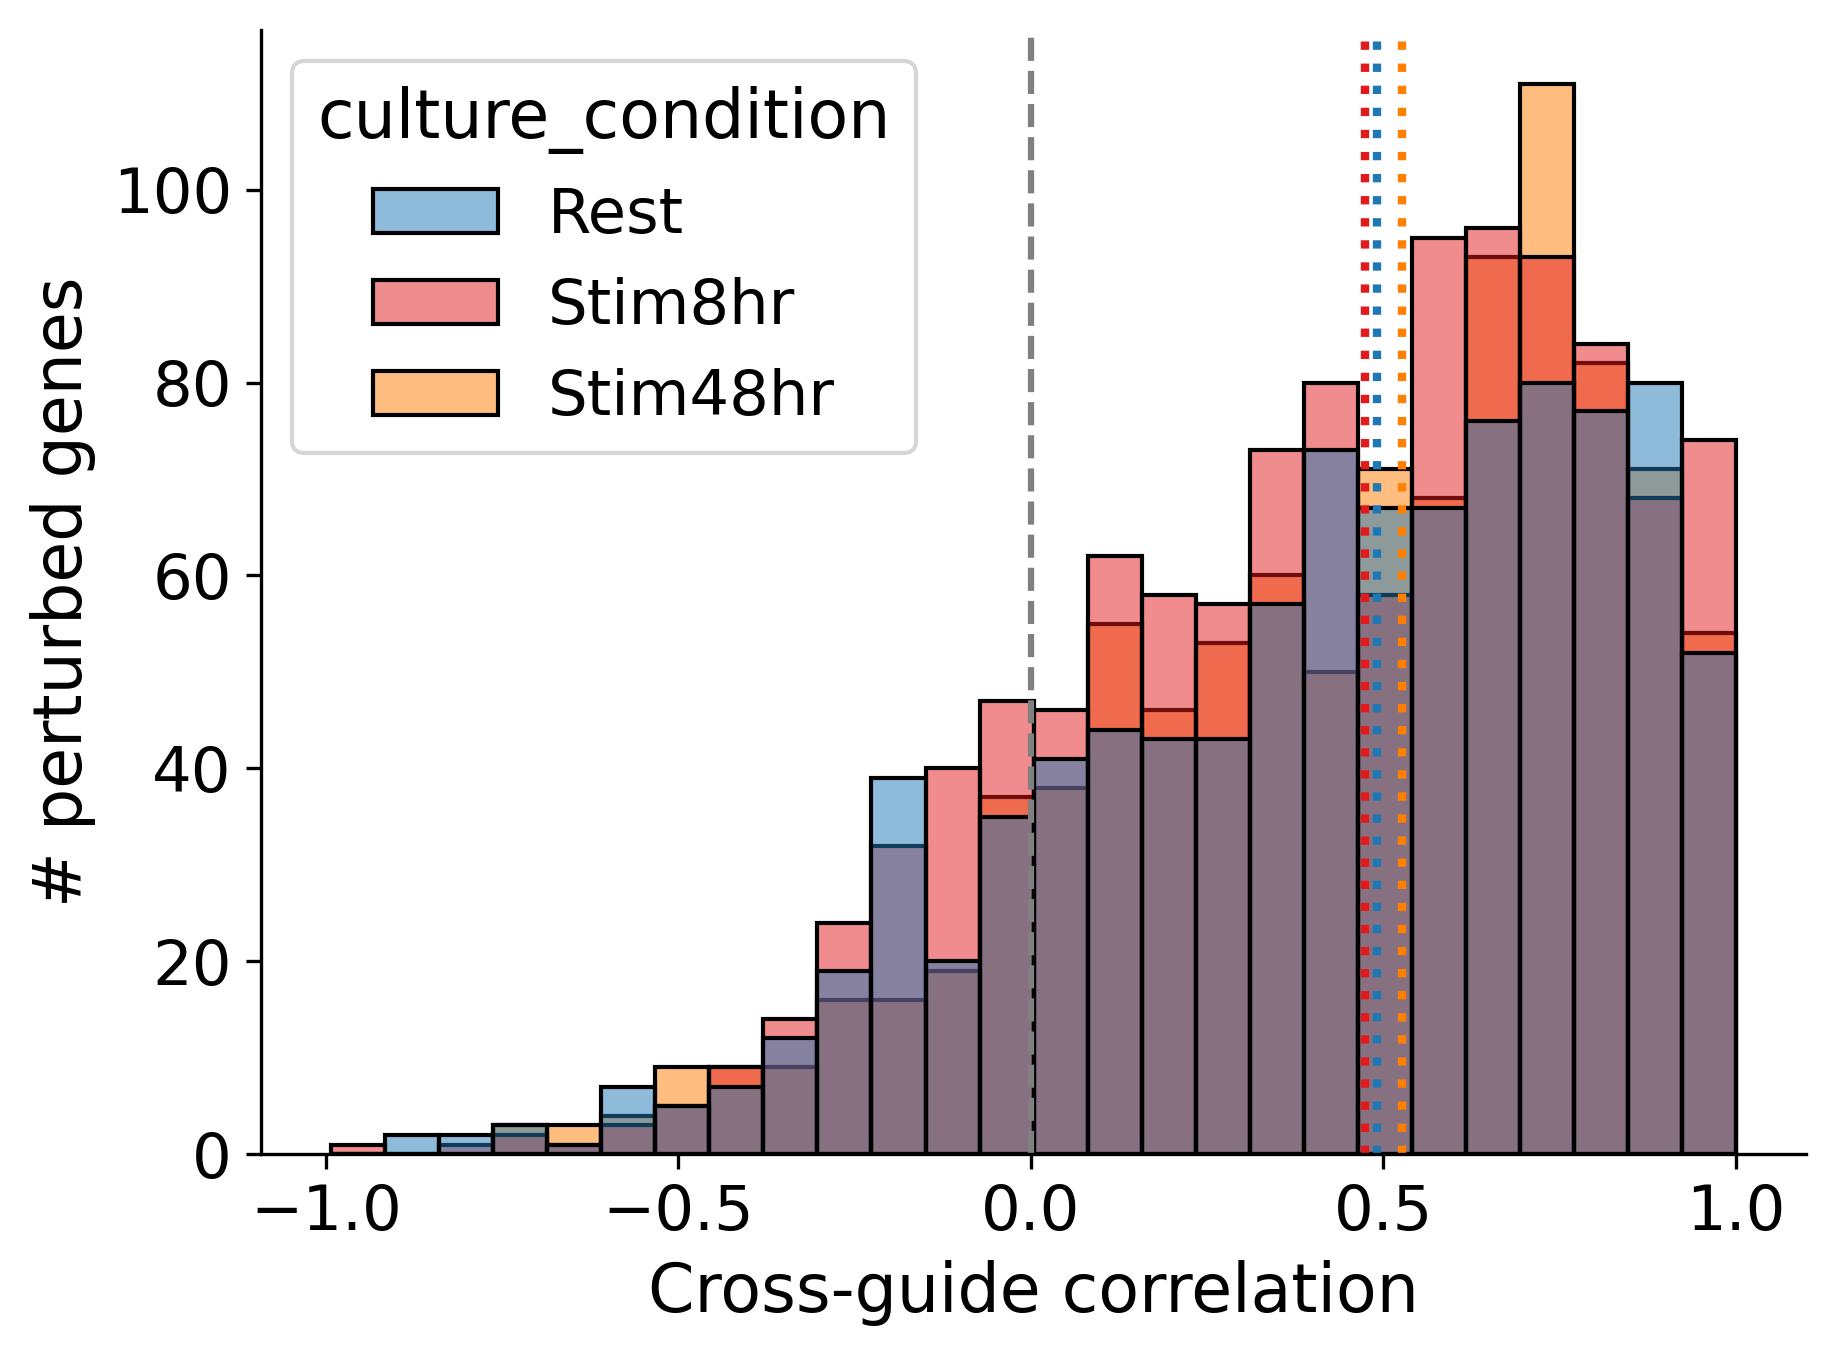

In [54]:
sns.histplot(
    data=correlations_df.reset_index(),
    x='correlation',
    hue='culture_condition',
    alpha=0.5,
    palette=palettes['culture_condition']
)
plt.axvline(x=0, linestyle='--', color='grey')
plt.xlabel('Cross-guide correlation')
plt.ylabel('# perturbed genes')

# Add dotted lines for the mean correlation in each condition
medians = correlations_df.groupby('culture_condition')['correlation'].median()
for cond, mean_val in medians.items():
    plt.axvline(x=mean_val, linestyle=':', color=palettes['culture_condition'].get(cond, 'black'), linewidth=2)

sns.despine()
plt.savefig('./results/guide_robustness.mean_corr_hist.pdf')
plt.savefig('./results/guide_robustness.mean_corr_hist.png')

In [ ]:
medians


culture_condition
Rest        0.491390
Stim48hr    0.526324
Stim8hr     0.473632
Name: correlation, dtype: float64

In [41]:
# # Calculate mean and standard error per target and condition
# summary_stats = correlations_df.groupby(['target', 'culture_condition']).agg({
#     'correlation': ['mean', 'std', 'count'],
#     'correlation_ceiling': ['mean', 'std']
# }).reset_index()

# # Fill NAs in correlation_ceiling with 0
# summary_stats[('correlation_ceiling', 'mean')] = summary_stats[('correlation_ceiling', 'mean')].fillna(0)
# summary_stats[('correlation_ceiling', 'std')] = summary_stats[('correlation_ceiling', 'std')].fillna(0)

# # Calculate standard errors
# summary_stats['correlation_se'] = summary_stats[('correlation', 'std')] / np.sqrt(summary_stats[('correlation', 'count')])
# summary_stats['correlation_ceiling_se'] = summary_stats[('correlation_ceiling', 'std')] / np.sqrt(summary_stats[('correlation', 'count')])

# # Create figure with subplots for each condition plus boxplot
# conditions = ['Rest', 'Stim8hr', 'Stim48hr']
# ylabel = 'DE effect correlation\n(across donors)'
# correlations_df['culture_condition'] = correlations_df['culture_condition'].astype('category').cat.reorder_categories(conditions)
# fig, axes = plt.subplots(1, len(conditions) + 1, figsize=(6*(len(conditions) + 1), 6), sharey=True, gridspec_kw={'width_ratios': [1, 2, 2, 2]})

# # Add violinplot in the first subplot with reduced width
# sns.violinplot(data=correlations_df.reset_index(), x='culture_condition', y='correlation', hue='culture_condition', ax=axes[0],
#             order=conditions, palette=palettes['culture_condition'], density_norm='width', cut=0, width=0.7,
#             legend=True)
# axes[0].legend(title='Culture condition', bbox_to_anchor=(1.2, 1.15), loc='right', ncol=3, frameon=False)
# axes[0].set_xlabel('Culture condition', fontsize=14)
# axes[0].set_ylabel(ylabel, fontsize=14)
# axes[0].tick_params(axis='both', labelsize=12)
# axes[0].axhline(y=0, color='black', linestyle=':', alpha=0.5)  # Add dotted line at y=0

# for i, condition in enumerate(conditions):
#     condition_stats = summary_stats[summary_stats['culture_condition'] == condition]
    
#     # Get axis limits for this condition
#     min_val = min(condition_stats[('correlation_ceiling', 'mean')].min(), condition_stats[('correlation', 'mean')].min())
#     max_val = max(condition_stats[('correlation_ceiling', 'mean')].max(), condition_stats[('correlation', 'mean')].max())
    
#     # Add diagonal line
#     axes[i+1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)
#     axes[i+1].axhline(0, color='black', linestyle='--', alpha=0.7)
    
#     # Plot error bars
#     axes[i+1].errorbar(x=condition_stats[('correlation_ceiling', 'mean')],
#                     y=condition_stats[('correlation', 'mean')],
#                     xerr=condition_stats['correlation_ceiling_se'],
#                     yerr=condition_stats['correlation_se'],
#                     fmt='o',
#                     color=palettes['culture_condition'][condition],
#                     alpha=0.7)
    
#     # Add labels with increased font size
#     axes[i+1].set_xlabel('Theoretical max correlation', fontsize=14)
#     axes[i+1].set_ylabel(ylabel, fontsize=14)
#     axes[i+1].tick_params(axis='both', labelsize=12)
    
#     # Add target names as annotations only for genes with mean correlation < 0.1
#     for j, target in enumerate(condition_stats['target']):
#         if condition_stats[('correlation', 'mean')].iloc[j] < 0.1:
#             axes[i+1].annotate(target,
#                            (condition_stats[('correlation_ceiling', 'mean')].iloc[j],
#                             condition_stats[('correlation', 'mean')].iloc[j]),
#                            xytext=(5, 5), textcoords='offset points',
#                            alpha=0.7,
#                            fontsize=12)

# plt.tight_layout(w_pad=0.5)
# plt.savefig('../results/donor_robustness_figure.pdf')
# plt.savefig('../results/donor_robustness_figure.png')

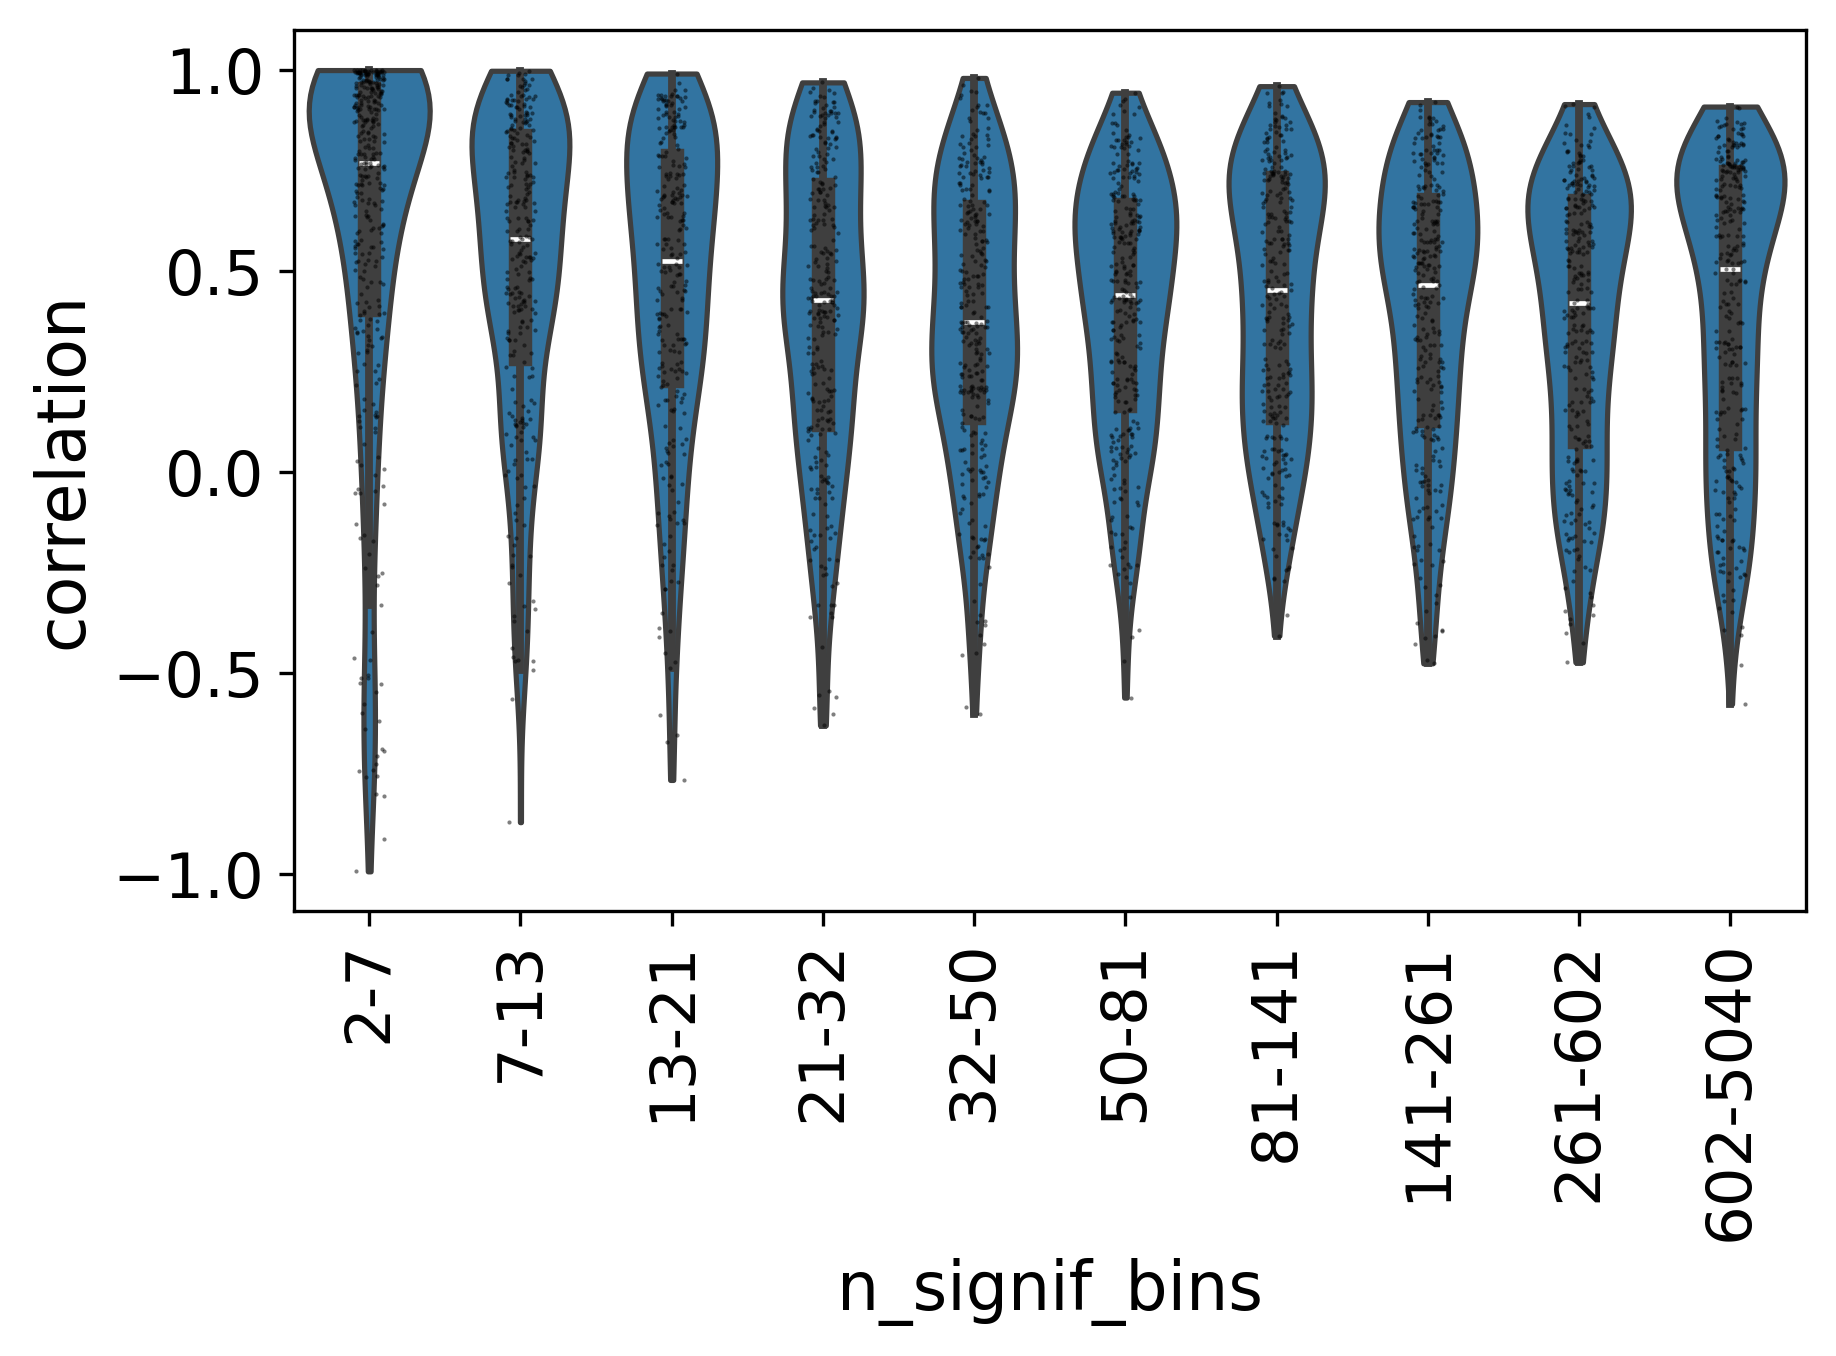

In [45]:
# Create bins and get the bin edges
bins = pd.qcut(correlations_df['n_signif_union'], q=10)
bin_labels = [f'{int(b.left)}-{int(b.right)}' for b in sorted(bins.unique(), key=lambda x: x.left)]
correlations_df['n_signif_bins'] = pd.qcut(correlations_df['n_signif_union'], q=10, labels=bin_labels)
sns.violinplot(data=correlations_df, x='n_signif_bins', y='correlation', cut=0);
sns.stripplot(data=correlations_df, x='n_signif_bins', y='correlation', size=1, color='black', alpha=0.5);
plt.xticks(rotation=90);

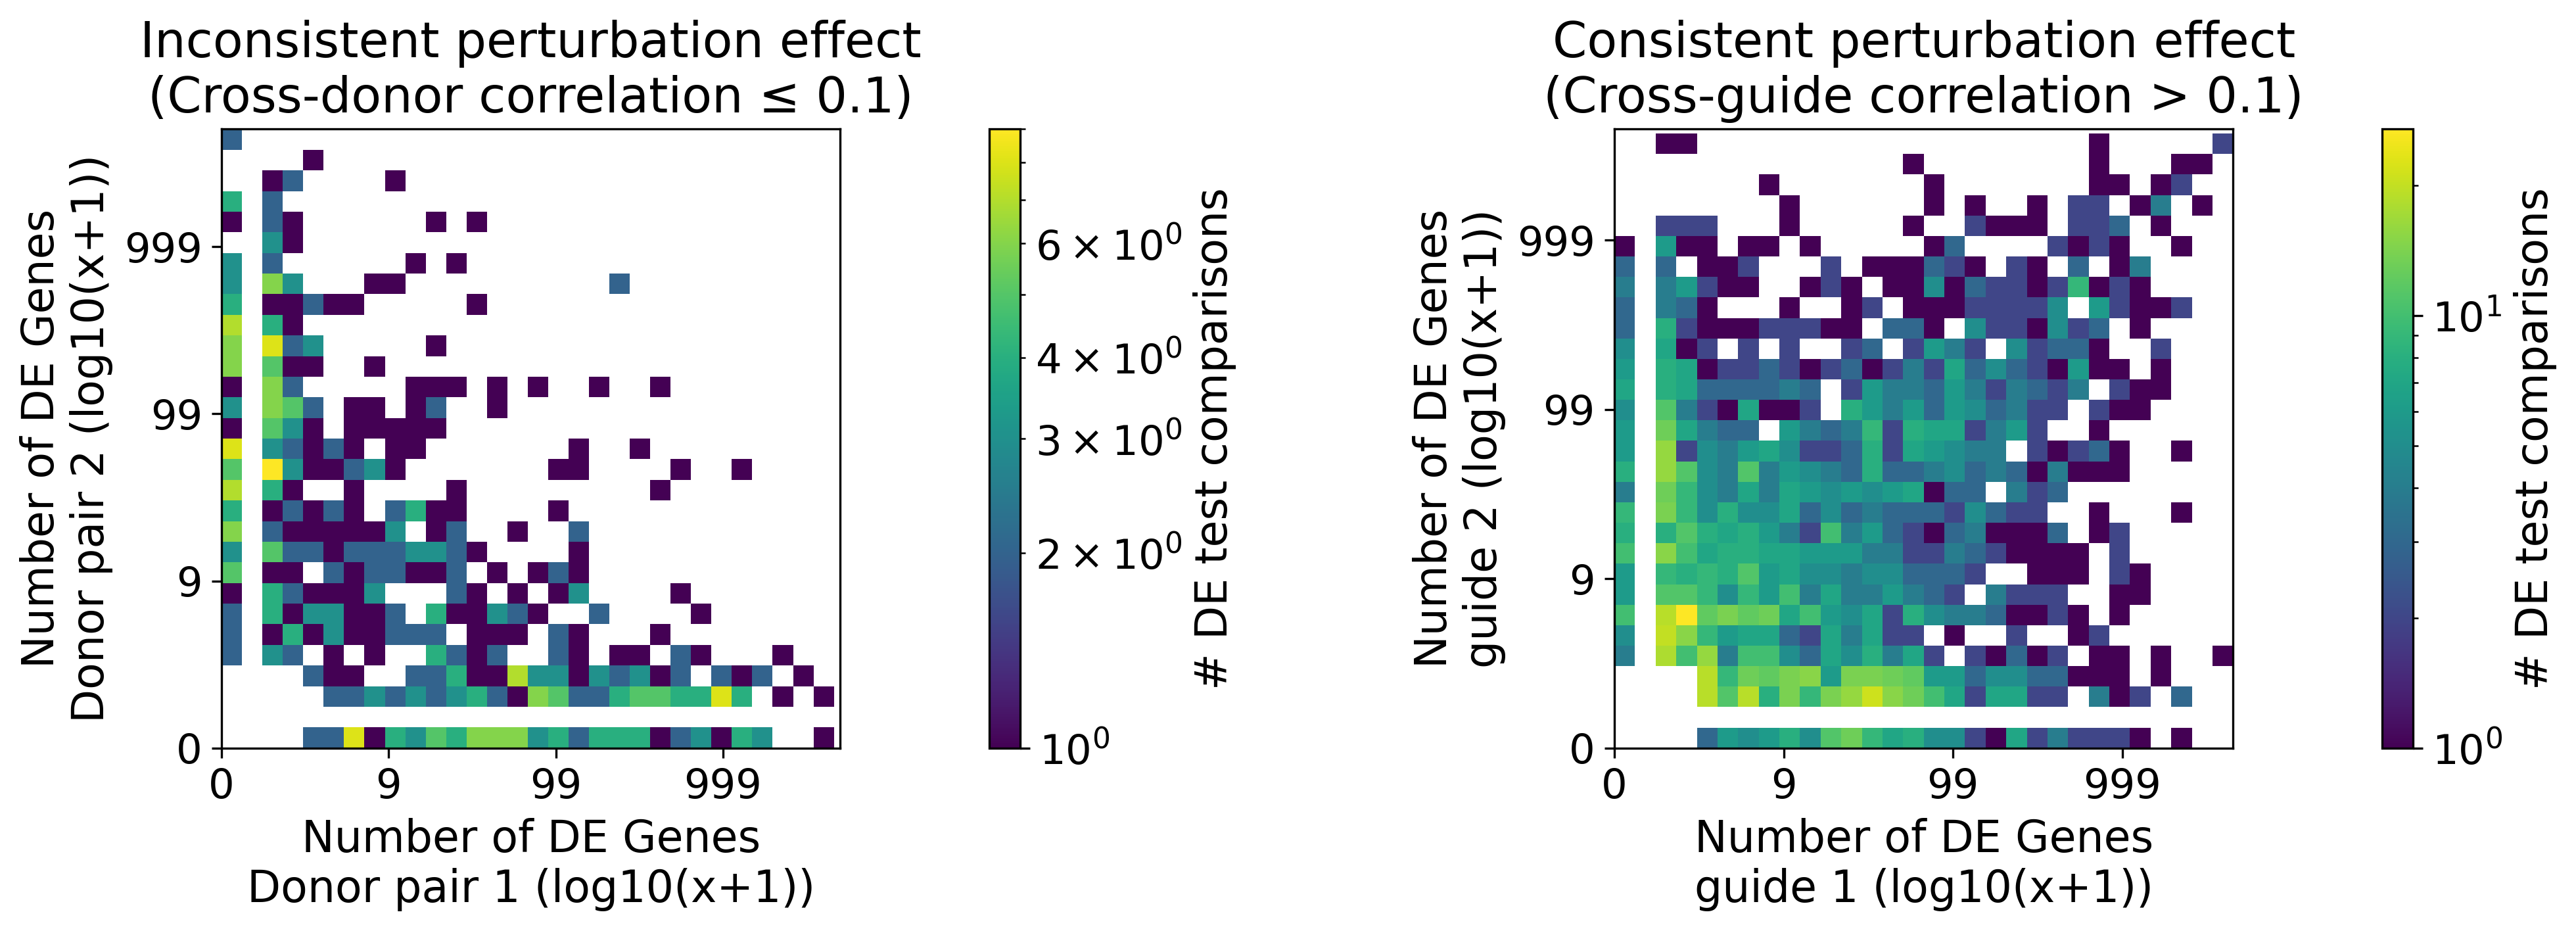

In [56]:
thresh = 0.1
pl_df = correlations_df.copy()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
h_low = plt.hist2d(
    np.log10(pl_df[pl_df['correlation'] <= thresh]['n_signif_1'] + 1), 
    np.log10(pl_df[pl_df['correlation'] <= thresh]['n_signif_2'] + 1), 
    bins=30, 
    norm=matplotlib.colors.LogNorm(), 
    cmap='viridis'
)
cbar_low = plt.colorbar(h_low[3], label='# DE test comparisons')
cbar_low.ax.set_ylim(cbar_low.ax.get_ylim()[0], h_low[3].get_array().max())

plt.xlabel('Number of DE Genes\nDonor pair 1 (log10(x+1))')
plt.ylabel('Number of DE Genes\nDonor pair 2 (log10(x+1))')
plt.title(f'Inconsistent perturbation effect\n(Cross-donor correlation ≤ {thresh})')

# Add custom tick labels for original values
def log_ticks_formatter(x, pos):
    return str(int(np.power(10, x) - 1))

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))

# Make x and y axes have equal scale
plt.axis('square')

plt.subplot(1, 2, 2)
h_high = plt.hist2d(
    np.log10(pl_df[pl_df['correlation'] > thresh]['n_signif_1'] + 1), 
    np.log10(pl_df[pl_df['correlation'] > thresh]['n_signif_2'] + 1), 
    bins=30, 
    norm=matplotlib.colors.LogNorm(), 
    cmap='viridis'
)
cbar_high = plt.colorbar(h_high[3], label='# DE test comparisons')
cbar_high.ax.set_ylim(cbar_high.ax.get_ylim()[0], h_high[3].get_array().max())

plt.xlabel('Number of DE Genes\nguide 1 (log10(x+1))')
plt.ylabel('Number of DE Genes\nguide 2 (log10(x+1))')
plt.title(f'Consistent perturbation effect\n(Cross-guide correlation > {thresh})')

# Add custom tick labels for original values
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))

# Make x and y axes have equal scale
plt.axis('square')

plt.tight_layout()
plt.savefig('./results/guide_robustness.n_de_genes_scatter.pdf')
plt.savefig('./results/guide_robustness.n_de_genes_scatter.png')

## Consider on-target effect

In [66]:
combined_de_adata.obs['guide_id'] = combined_de_adata.obs['target_contrast'].copy()
combined_de_adata.obs['target_contrast'] = combined_de_adata.obs['target_contrast_gene_name']

In [81]:
combined_de_adata.obs['target_contrast']

ADAT3-2_Stim8hr       ADAT3
AP1S2-2_Stim8hr       AP1S2
ARPC2-2_Stim8hr       ARPC2
ARPC3-2_Stim8hr       ARPC3
BCAP29-2_Stim8hr     BCAP29
                      ...  
TXNDC9-2_Stim48hr    TXNDC9
USP22-2_Stim48hr      USP22
UTP23-1_Stim48hr      UTP23
UTP23-2_Stim48hr      UTP23
VBP1-1_Stim48hr        VBP1
Name: target_contrast, Length: 6508, dtype: category
Categories (1796, object): ['A2M', 'AAGAB', 'AASDH', 'ABCA5', ..., 'ZSCAN23', 'ZSCAN25', 'ZSWIM4', 'ZSWIM9']

In [67]:
ontarget_guides_df = get_ontarget_effect(combined_de_adata, signif_estimate='adj_p_value', signif_alpha=0.1)

In [ ]:
all_targets = combined_de_adata.obs['target_contrast'].astype(str).unique()
combined_de_adata.var_names = combined_de_adata.var['gene_name'].values
measured_targets = combined_de_adata.var_names[combined_de_adata.var['gene_name'].isin(all_targets)].tolist()
measured_targets_names = combined_de_adata.var['gene_name'][combined_de_adata.var['gene_name'].isin(all_targets)].tolist()

ontarget_df = get_DE_results_long(
    combined_de_adata, 
    targets=measured_targets, genes=measured_targets_names, 
    effect_estimates=['log_fc', 'zscore', 'baseMean'],
    signif_estimate='adj_p_value',
    signif_alpha=0.1,
    target_id_col='target_contrast', 
    target_metadata_cols=['culture_condition']
)
ontarget_df = ontarget_df[ontarget_df['gene'] == ontarget_df['target_contrast']].copy()

In [92]:
combined_de_adata

AnnData object with n_obs × n_vars = 6508 × 11400
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'guide_id'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [103]:
correlations_df

,Unnamed: 0,target,correlation,correlation_ceiling,n_signif_union,n_signif_1,n_signif_2,culture_condition
0,0,A2M,-0.466086,NaN,10,0,10,Rest
1,1,ABCC1,0.084480,NaN,84,84,1,Rest
2,2,ABHD12,0.490760,0.628502,360,1,360,Rest
3,3,ABHD13,-0.301527,0.527995,507,506,3,Rest
4,4,ABHD14A,0.958795,0.943289,5,1,5,Rest
...,...,...,...,...,...,...,...,...
3047,3047,ZNF655,0.761569,0.481366,20,1,20,Stim48hr
3048,3048,ZNF658,0.538926,NaN,14,0,14,Stim48hr
3049,3049,ZNF829,0.628259,0.886746,52,52,1,Stim48hr
3050,3050,ZNF837,0.565384,0.863103,83,1,82,Stim48hr


/tmp/ipykernel_152310/2129415383.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['target_contrast_gene_name', 'culture_condition'])['significant']


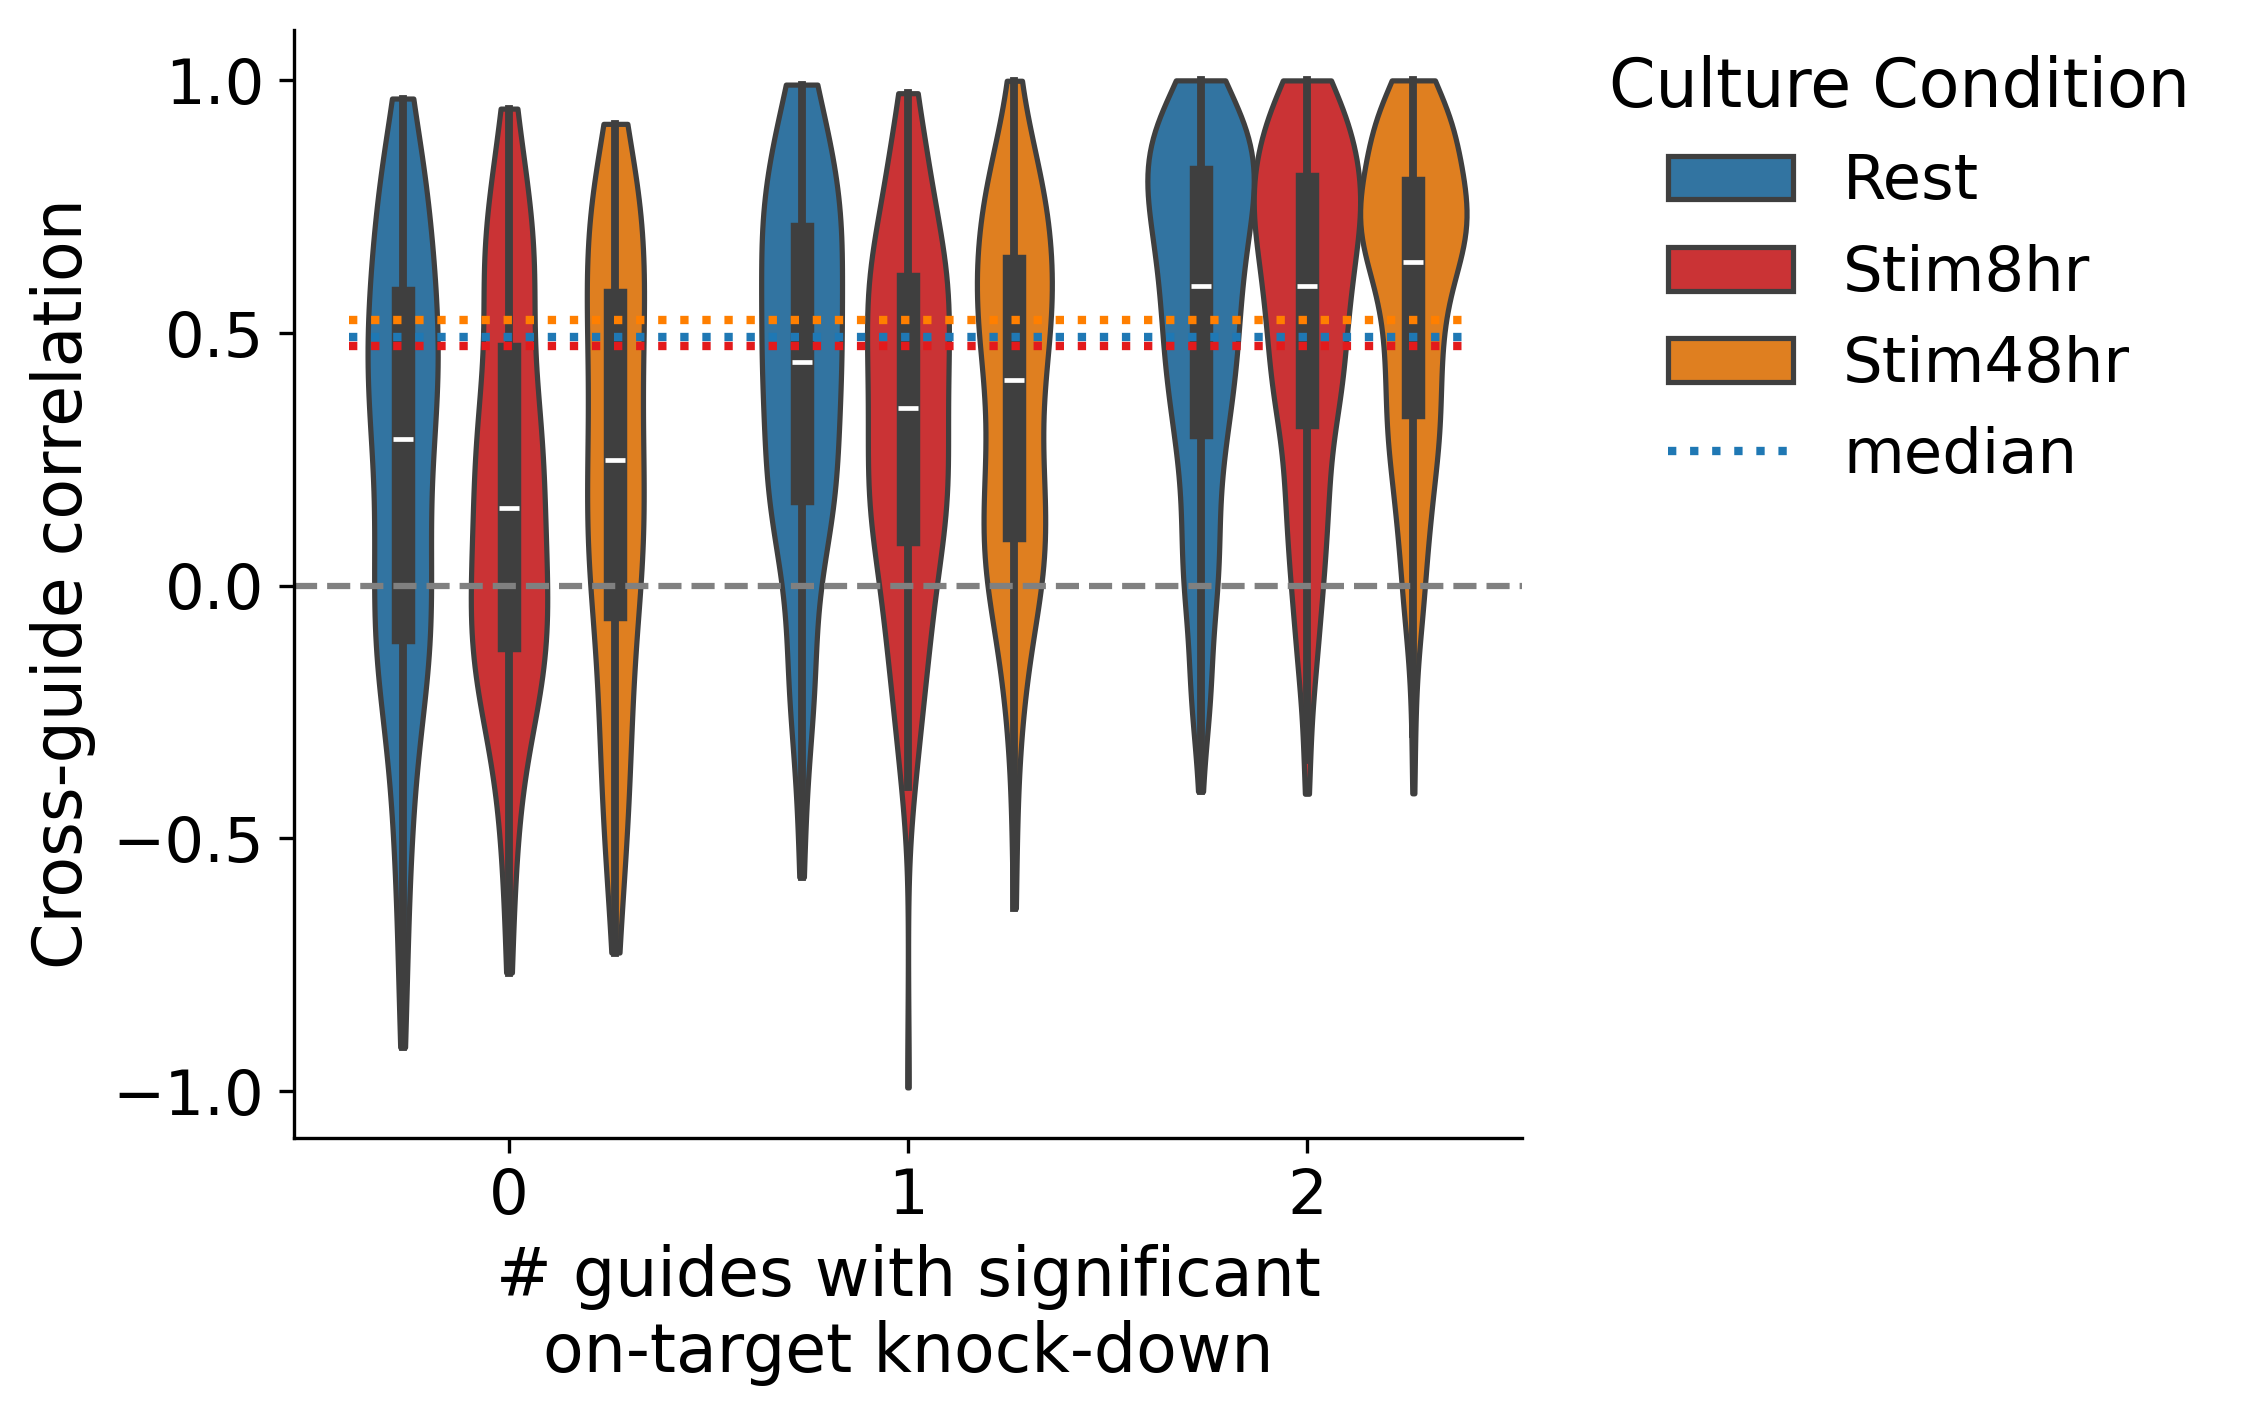

In [118]:
n_ontarget_significant = (
    pd.concat(
        [combined_de_adata.obs, ontarget_df.set_index('index')[['zscore', 'significant']]],
        axis=1
    )
    .groupby(['target_contrast_gene_name', 'culture_condition'])['significant']
    .sum()
    .reset_index()
)

pl_df = pd.merge(
    correlations_df, 
    n_ontarget_significant.rename(columns={'target_contrast_gene_name': 'target'})
)

plt.figure(figsize=(8, 5))
ax = sns.violinplot(
    data=pl_df,
    x='significant',
    y='correlation',
    hue='culture_condition',
    palette=palettes['culture_condition'],
    cut=0
)

# For each culture_condition, add a single dotted line at the median of all its points (across all significance levels)
culture_conditions = pl_df['culture_condition'].unique()
significant_ticks = sorted(pl_df['significant'].unique())
tick_min = -0.4
tick_max = len(significant_ticks) - 1 + 0.4

for i, condition in enumerate(culture_conditions):
    mask = pl_df['culture_condition'] == condition
    if mask.sum() > 0:
        med = pl_df.loc[mask, 'correlation'].median()
        ax.hlines(
            y=med,
            xmin=tick_min,
            xmax=tick_max,
            colors=palettes['culture_condition'][condition],
            linestyles='dotted',
            linewidth=2,
            label=f"median" if i == 0 else None,
            zorder=3,
        )
ax.axhline(y=0, color='grey', linestyle='--')
# Move the legend outside the plot
ax.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    borderaxespad=0., 
    title="Culture Condition",
    frameon=False
)
plt.ylabel('Cross-guide correlation')
plt.xlabel('# guides with significant\non-target knock-down')
sns.despine()
plt.tight_layout()
plt.savefig('./results/guide_robustness.w_ontarget_effect.pdf')
plt.savefig('./results/guide_robustness.w_ontarget_effect.png')


In [119]:
pl_df.value_counts('significant')

significant
2    1829
0     732
1     491
Name: count, dtype: int64

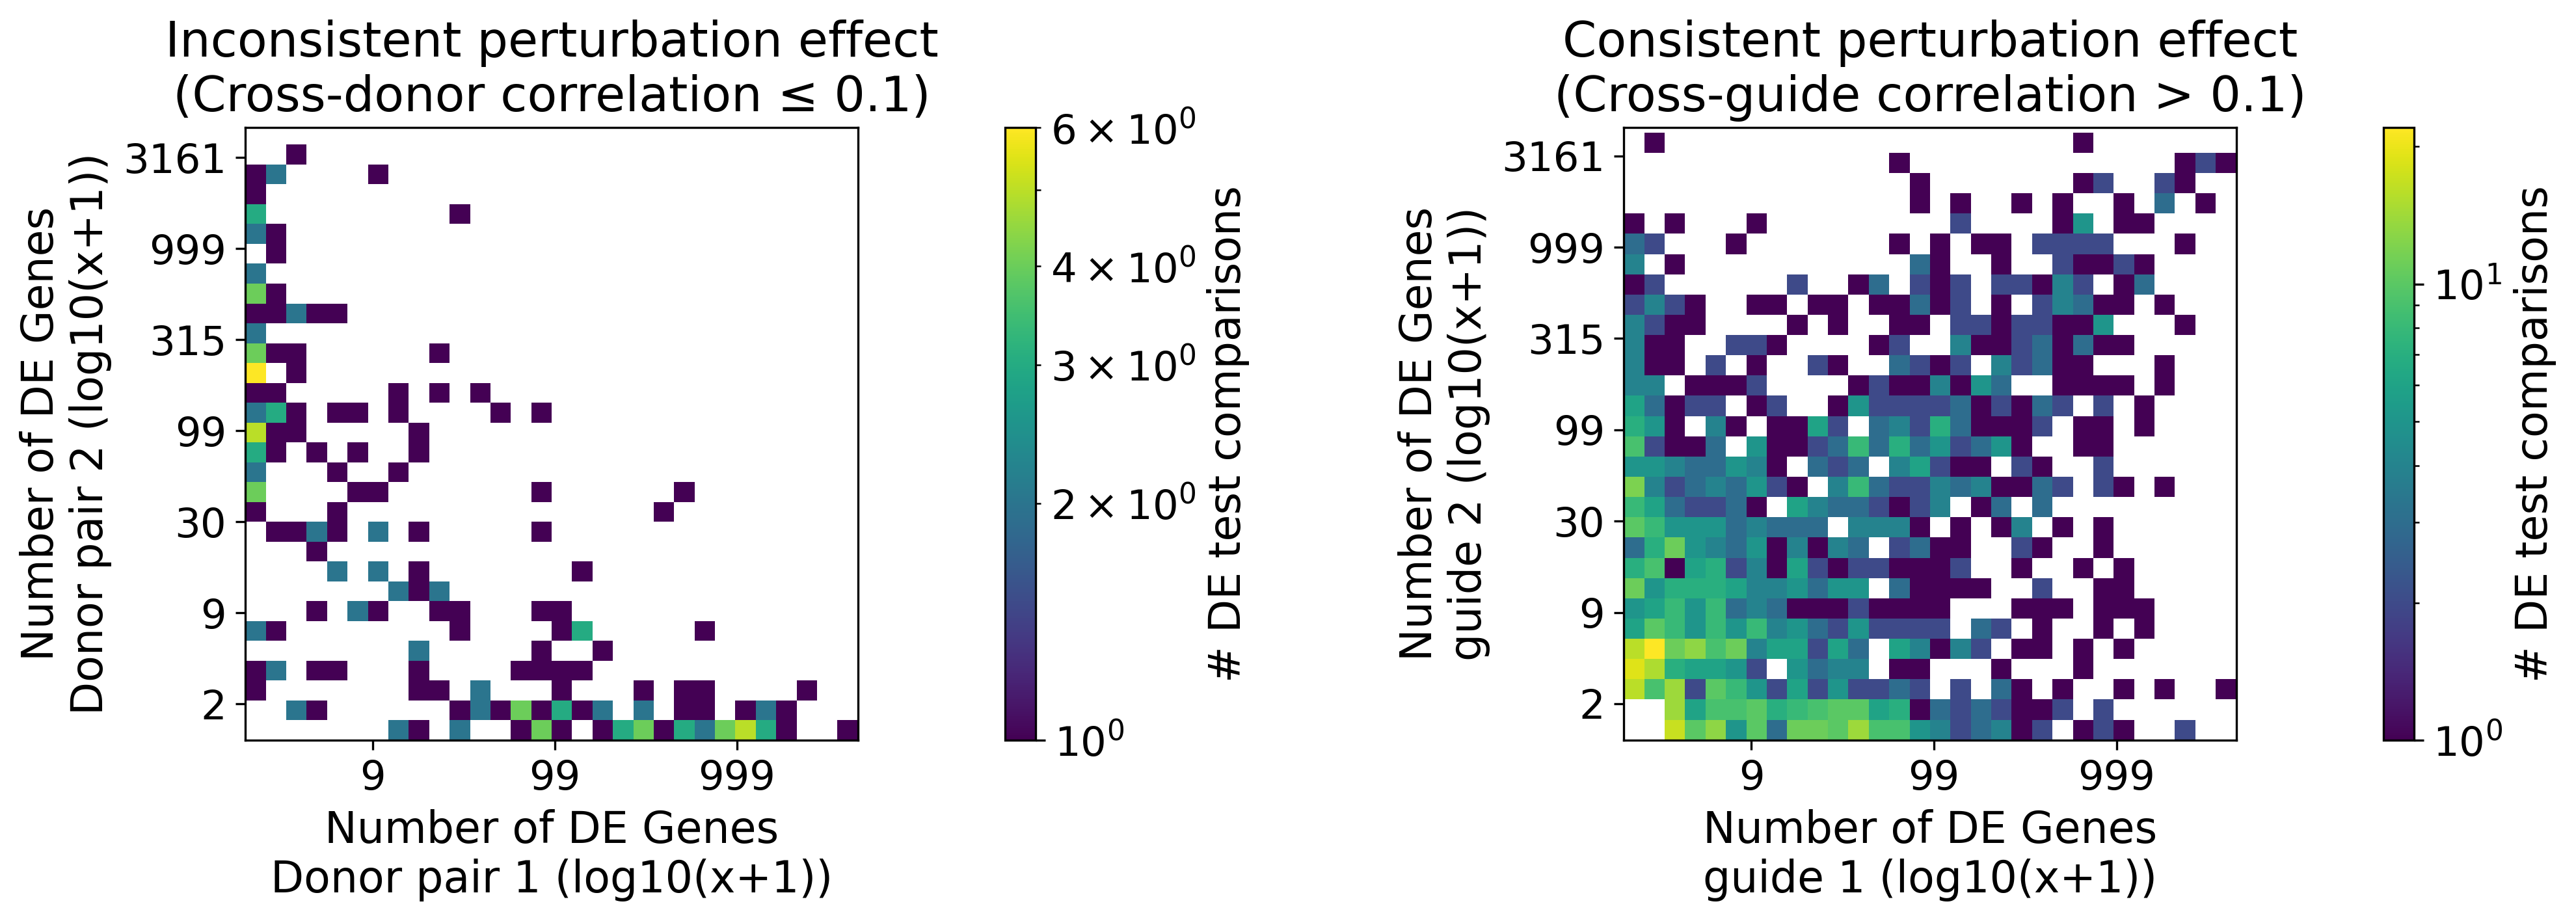

In [120]:
thresh = 0.1
pl_df = pd.merge(
    correlations_df, 
    n_ontarget_significant.rename(columns={'target_contrast_gene_name': 'target'})
)
pl_df = pl_df[pl_df['significant'] == 2].copy()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
h_low = plt.hist2d(
    np.log10(pl_df[pl_df['correlation'] <= thresh]['n_signif_1'] + 1), 
    np.log10(pl_df[pl_df['correlation'] <= thresh]['n_signif_2'] + 1), 
    bins=30, 
    norm=matplotlib.colors.LogNorm(), 
    cmap='viridis'
)
cbar_low = plt.colorbar(h_low[3], label='# DE test comparisons')
cbar_low.ax.set_ylim(cbar_low.ax.get_ylim()[0], h_low[3].get_array().max())

plt.xlabel('Number of DE Genes\nDonor pair 1 (log10(x+1))')
plt.ylabel('Number of DE Genes\nDonor pair 2 (log10(x+1))')
plt.title(f'Inconsistent perturbation effect\n(Cross-donor correlation ≤ {thresh})')

# Add custom tick labels for original values
def log_ticks_formatter(x, pos):
    return str(int(np.power(10, x) - 1))

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))

# Make x and y axes have equal scale
plt.axis('square')

plt.subplot(1, 2, 2)
h_high = plt.hist2d(
    np.log10(pl_df[pl_df['correlation'] > thresh]['n_signif_1'] + 1), 
    np.log10(pl_df[pl_df['correlation'] > thresh]['n_signif_2'] + 1), 
    bins=30, 
    norm=matplotlib.colors.LogNorm(), 
    cmap='viridis'
)
cbar_high = plt.colorbar(h_high[3], label='# DE test comparisons')
cbar_high.ax.set_ylim(cbar_high.ax.get_ylim()[0], h_high[3].get_array().max())

plt.xlabel('Number of DE Genes\nguide 1 (log10(x+1))')
plt.ylabel('Number of DE Genes\nguide 2 (log10(x+1))')
plt.title(f'Consistent perturbation effect\n(Cross-guide correlation > {thresh})')

# Add custom tick labels for original values
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_ticks_formatter))

# Make x and y axes have equal scale
plt.axis('square')

plt.tight_layout()
plt.savefig('./results/guide_robustness.n_de_genes_scatter.pdf')
plt.savefig('./results/guide_robustness.n_de_genes_scatter.png')
